### This model demonstrates how to adversarially attack a model, extract representations, analyze with MFTMA, and plot the results.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from glob import glob

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from art.utils import load_cifar10

In [3]:
seed = 0

# specify stimuli and adversarial conditions

## class manifolds analysis example parameters 
manifold_type = 'class' # 'class' for traditional label based manifolds, 'exemplar' for individual exemplar manifolds
P = 10 # number of manifolds
M = 50 # number of examples per manifold
N = 2000 # maximum number of features to use

eps = 1/255
max_iter = 16
eps_step_factor = 4
eps_step = eps / eps_step_factor
random = False # adversarial perturbation if false, random perturbation if true

## OR: exemplar manifolds analysis example parameters 
# manifold_type = 'exemplar' # 'class' for traditional label based manifolds, 'exemplar' for individual exemplar manifolds
# P = 50 # number of manifolds
# M = 50 # number of examples per manifold
# N = 2000 # maximum number of features to use

# eps = 8/255
# max_iter = 1
# eps_step_factor = 1
# eps_step = eps / eps_step_factor
# random = False # adversarial perturbation if false, random perturbation if true


# and model and dataset details

## regular VOneResNet18
model_name = 'CIFAR_ResNet18'

## regular VOneResNet18 with Gaussian noise
# model_name = 'CIFAR_VOneResNet18'

dataset = 'CIFAR'

# where to save results and how to name the files
results_dir = 'results'
file_name = f'model_{model_name}-manifold_{manifold_type}-eps_{eps}-iter_{max_iter}-random_{random}-seed_{seed}.csv'

## Load a model and dataset

In [4]:
from helpers import load_model, art_wrap_model, accuracy

In [ ]:
# load the model
model = torch.load(model_location, map_location='cpu')
model = load_model()

# wrap the model with adversarial robustness toolbox, for generating adversarial stimuli.
classifier = art_wrap_model(model)

((50000, 3, 32, 32), (10000, 3, 32, 32))

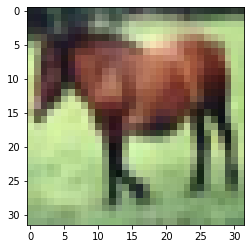

In [6]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_cifar10()
plt.imshow(x_train[7])

x_train = x_train.transpose(0,3,1,2).astype(np.float32)
x_test = x_test.transpose(0,3,1,2).astype(np.float32)

x_train.shape, x_test.shape

In [7]:
# get model clean accuracy
predictions = classifier.predict(x_test)
clean_accuracy = accuracy(predictions, y_test)
print("Accuracy on benign test examples: {}%".format(clean_accuracy * 100))

Accuracy on benign test examples: 94.91000000000001%


## Generate adversarial manifold stimuli

In [8]:
from helpers import perturb_stimuli, construct_manifold_stimuli

In [ ]:
X, Y = construct_manifold_stimuli(x_test, y_test, manifold_type, P=P, M=M)
X_adv = perturb_stimuli(
    X, 
    Y, 
    classifier, 
    eps=eps, 
    eps_step_factor=eps_step_factor, 
    max_iter=max_iter, 
    random=random
)

print(f'stimuli shape: {X_adv.shape}')

# get adversarial accuracy
adv_accuracy = accuracy(classifier.predict(X_adv), Y)
print(f"Accuracy on adversarial test examples: {adv_accuracy * 100}")

## Extract and MFTMA analyze the representations

In [10]:
from helpers import Hook, model_layer_map, MFTMA_analyze_activations

In [11]:
# apply hooks to the model, to extract intermediate representations
hooks = {}

for layer_name, module in model_layer_map(model_name, model).items():
    hooks[layer_name] = Hook(module, layer_name)

In [12]:
# run the perturbed stimuli through the model
Y_hat = model(torch.tensor(X_adv))

# put activations and pixels into a dictionary with layer names
features_dict = {layer_name: hook.activations for layer_name, hook in hooks.items()}
features_dict['0.pixels'] = X_adv

In [13]:
# run MFTMA analysis on the features
df = MFTMA_analyze_activations(features_dict, P, M, N=N, seed=seed)

## add additional meta data
df['model'] = model_name
df['manifold_type'] = manifold_type
df['eps'] = eps
df['eps_step'] = eps_step
df['max_iter'] = max_iter
df['random'] = random

In [14]:
# store the results
df.to_csv(os.path.join(results_dir, file_name))

## run multiple seeds and models
Here, all of the above is wrapped together into a single function, for easier use.

In [5]:
from helpers import MFTMA_analyze_adversarial_representations

In [ ]:
models = ['CIFAR_ResNet18', 'CIFAR_VOneResNet18']

args_sets = [
    dict(seeds=5,
         manifold_type=manifold_type,
         P=P,
         M=M,
         N=N,
         eps=eps,
         eps_step_factor=eps_step_factor,
         max_iter=max_iter,
         random=random,
         model_name=model,
         dataset=dataset,
         device='cpu')
    for model in models
]

for args in args_sets:
    MFTMA_analyze_adversarial_representations(args)

## Load past results and plot

In [4]:
from helpers import plot_layerwise

In [5]:
# load subsequent results with CIFAR dataset
files = [y for x in os.walk(results_dir) for y in glob(os.path.join(x[0], f'*{dataset}*'))]
df = pd.concat([pd.read_csv(f) for f in files])
df.head(3)

,Unnamed: 0,cap,dim,rad,mean_cap,center_corr,K,EVD90,PR,P,M,N,layer,seed,model,manifold_type,eps,eps_step,max_iter,random
0,0,0.046595,33.183776,1.329492,0.040919,0.151744,1,372,279.929796,10,50,2000,1.VOneBlock.Noise,0,CIFAR_VOneResNet18,class,0.003922,0.00098,16,False
1,1,0.039163,36.399311,1.501994,0.040919,0.151744,1,372,279.929796,10,50,2000,1.VOneBlock.Noise,0,CIFAR_VOneResNet18,class,0.003922,0.00098,16,False
2,2,0.039733,36.303916,1.514884,0.040919,0.151744,1,372,279.929796,10,50,2000,1.VOneBlock.Noise,0,CIFAR_VOneResNet18,class,0.003922,0.00098,16,False


In [10]:
# define MFTMA and other measures to plot
measures = ['mean_cap', 'dim', 'rad', 'center_corr', 'EVD90', 'PR']

### Plot class manifold results layerwise

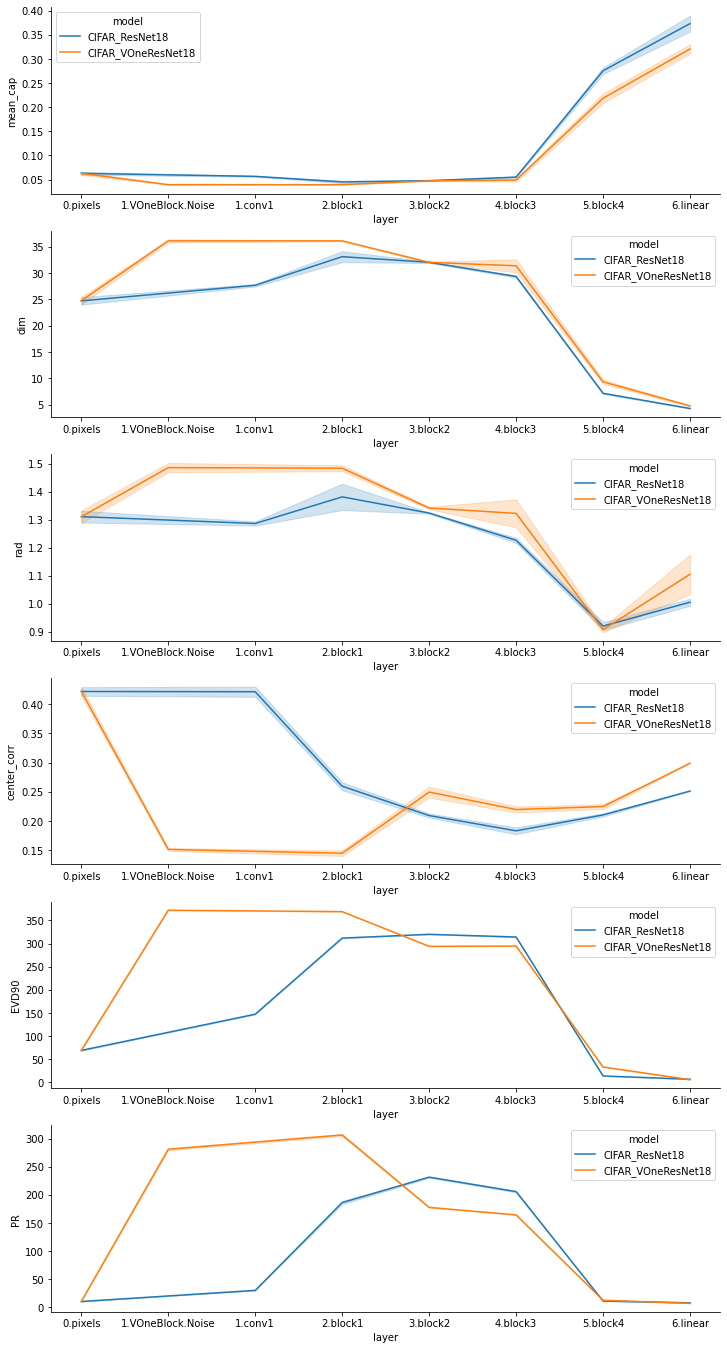

In [11]:
manifold_type = 'class' # 'class' for traditional label based manifolds, 'exemplar' for individual exemplar manifolds
eps = 1/255
plot_layerwise(df, measures, eps=eps, manifold_type=manifold_type)

### Plot exemplar manifold results layerwise

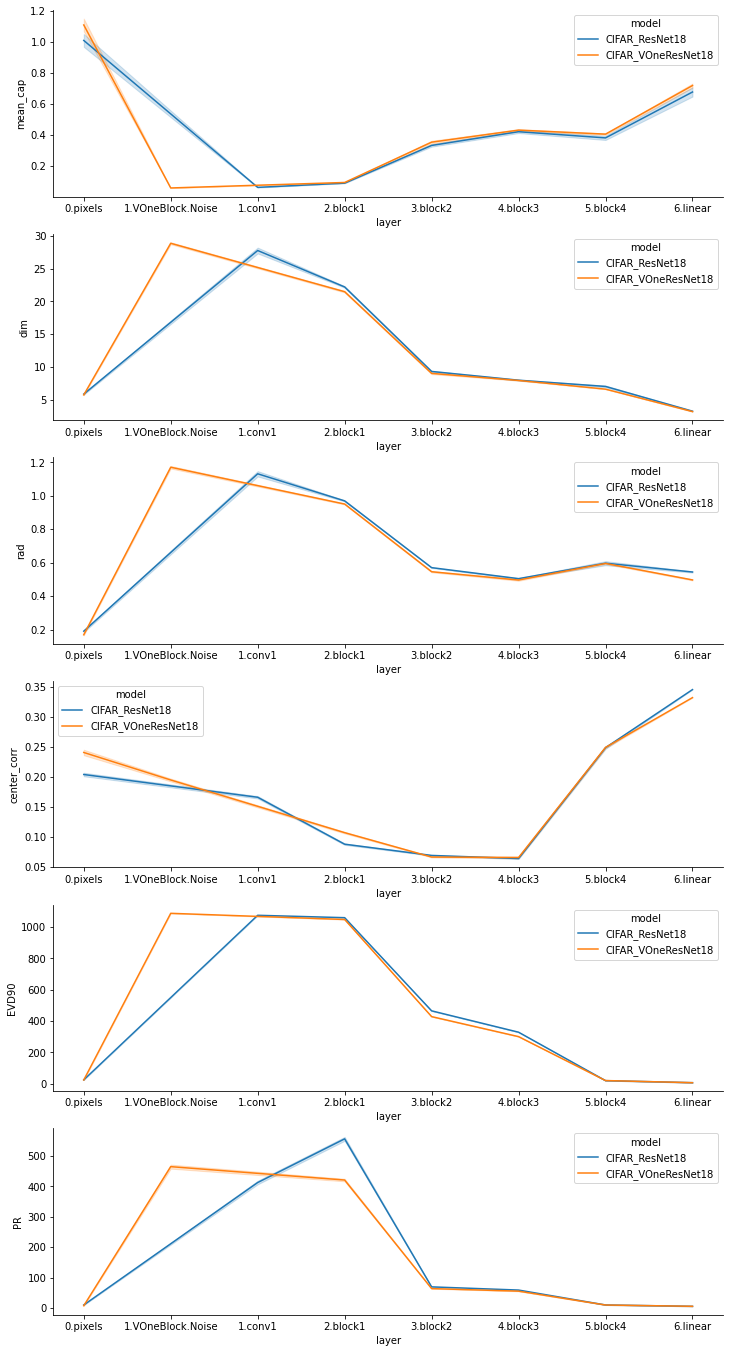

In [12]:
manifold_type = 'exemplar' # 'class' for traditional label based manifolds, 'exemplar' for individual exemplar manifolds
eps = 8/255
plot_layerwise(df, measures, eps=eps, manifold_type=manifold_type)